In [1]:
# Step 1: Import Necessary Libraries
import os
import time
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models
import torchvision.transforms as T
import matplotlib.cm as cm
from tqdm import tqdm

In [2]:
# Step 2: Define Utility Functions
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [3]:
#Set Device and Model Path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model_path = 'bisenet_model.pth'

cuda


In [4]:
#Specify Paths and Configuration
image_path = "/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic"
mask_path = "/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask"

In [5]:
#Load and Preprocess Data for Visualization
names2 = ['X_mask_190','X_mask_191','X_mask_192']
names = ['X_seismic_190','X_seismic_191','X_seismic_192']
images = [Image.open(os.path.join(image_path, name+'.png')) for name in names]
masks = [Image.open(os.path.join(mask_path, name+'.png')) for name in names2]

transforms = T.Compose([T.Grayscale(), T.ToTensor()])
x = torch.stack([transforms(image) for image in images])
y = torch.stack([transforms(mask) for mask in masks])

In [6]:
x.shape

torch.Size([3, 1, 369, 496])

In [7]:
y.shape

torch.Size([3, 1, 369, 496])

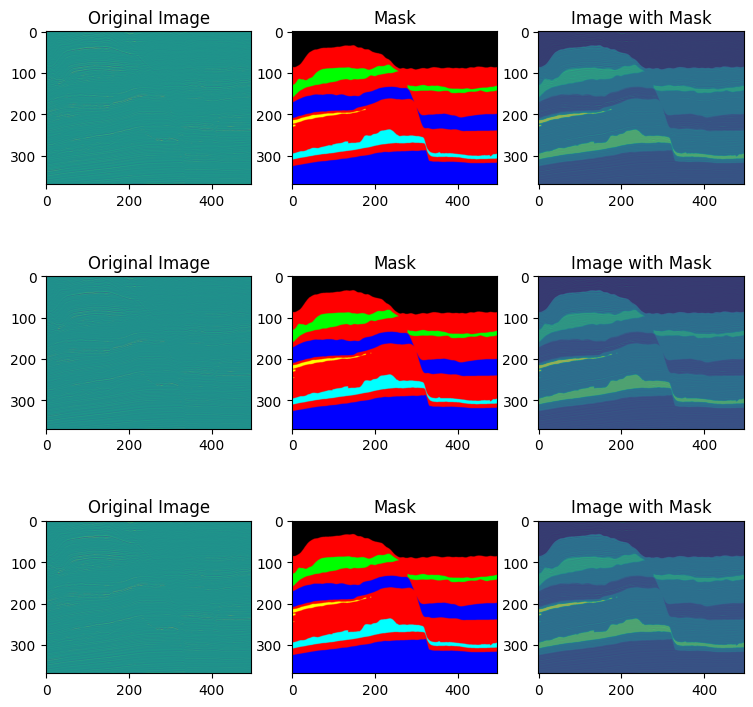

In [8]:
# Step 6: Visualize Sample Data
fig = plt.figure(figsize=(9, 9))
num_images = len(images)
for i in range(num_images):
    ax = fig.add_subplot(num_images, 3, i*3+1)
    ax.imshow(images[i])
    ax.set_title("Original Image")

    ax = fig.add_subplot(num_images, 3, i*3+2)
    ax.imshow(masks[i])
    ax.set_title("Mask")

    ax = fig.add_subplot(num_images, 3, i*3+3)
    ax.imshow(x[i].squeeze())
    ax.imshow(y[i].squeeze(), alpha=0.5)
    ax.set_title("Image with Mask")

plt.show()

In [9]:
# Step 7: Define Custom Dataset Class
class SegmentDataset(Dataset):

    color_encoding = [
                ('a', (0, 0, 0)),    # Black
                ('b', (255, 0, 0)),  # Red
                ('c', (0, 255, 0)),  # Green
                ('d', (0, 0, 255)),  # Blue
                ('e', (255, 255, 0)),  # Yellow
                ('f', (0, 255, 255))   # Cyan
    ]

    def __init__(self, image_paths, mask_paths, num_classes=7):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.num_classes=num_classes

#         self.transforms = T.Compose([T.Grayscale(), T.ToTensor()])
        self.transforms = T.Compose([T.ToTensor()])

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = image.convert('RGB')
        
        image = self.transforms(image)
        resized_image = T.Resize((204, 204))(image)
        
        mask = Image.open(self.mask_paths[idx])
        mask = mask.convert('RGB')
        mask = np.array(mask)
        mask = self.label_for_cross_entropy(mask)
        mask = Image.fromarray(mask)
        resized_mask = T.Resize((204, 204))(mask)
        resized_mask = np.array(resized_mask)
        
        return resized_image, torch.from_numpy(resized_mask).long()

    def label_for_cross_entropy(self, label):
        """
            Convert label image to matrix classes for apply cross entropy loss.
            Return semantic index, label in enumemap of H x W x class
        """
        semantic_map = np.zeros(label.shape[:-1])
        # Fill all value with class 13 - default for all pixels
        semantic_map.fill(self.num_classes - 1)
        # Fill the pixel with correct class

        for class_index, color_info in enumerate(self.color_encoding):
            color = color_info[1]
            equality = np.equal(label, color)
            class_map = np.all(equality, axis=-1)
            semantic_map[class_map] = class_index
        return semantic_map

    def __len__(self):
        return len(self.mask_paths)

In [10]:
import os
from sklearn.model_selection import train_test_split

# Paths to your image and mask folders
image_folder = "/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic"
mask_folder = "/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask"

# List all files in the image and mask folders
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith('.png')]
mask_files = [os.path.join(mask_folder, file).replace('seismic', 'mask') for file in image_files]

# Split files into training and validation sets
image_train, image_val, mask_train, mask_val = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

# Verify the lengths of the training and validation sets
print(f"Number of training samples: {len(image_train)}")
print(f"Number of validation samples: {len(image_val)}")

# Optionally, you can create separate lists for training and validation images and masks
training_image_paths = image_train
training_mask_paths = mask_train
val_image_paths = image_val
val_mask_paths = mask_val

/home/sang/Desktop/venv39/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Number of training samples: 625
Number of validation samples: 157


In [11]:
image_train

['/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_167.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_188.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_75.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_262.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_239.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_364.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_261.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_438.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_745.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_56.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_218.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_208.png',
 '/home/sang/Documents/Dataset/SEG_2020/ex

In [12]:
training_mask_paths

['/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_167.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_188.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_75.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_262.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_239.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_364.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_261.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_438.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_745.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_56.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_218.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_208.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_332.png',
 '/home/sang/Documents/Dataset/SEG_2020/

In [13]:
# Step 8: Initialize Dataset
train_dataset = SegmentDataset(training_image_paths, training_mask_paths)
# Step 5: Validation Dataset
val_dataset = SegmentDataset(val_image_paths, val_mask_paths)

In [14]:
# Step 6: Validation DataLoader
BATCH_SIZE = 16
dataloader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

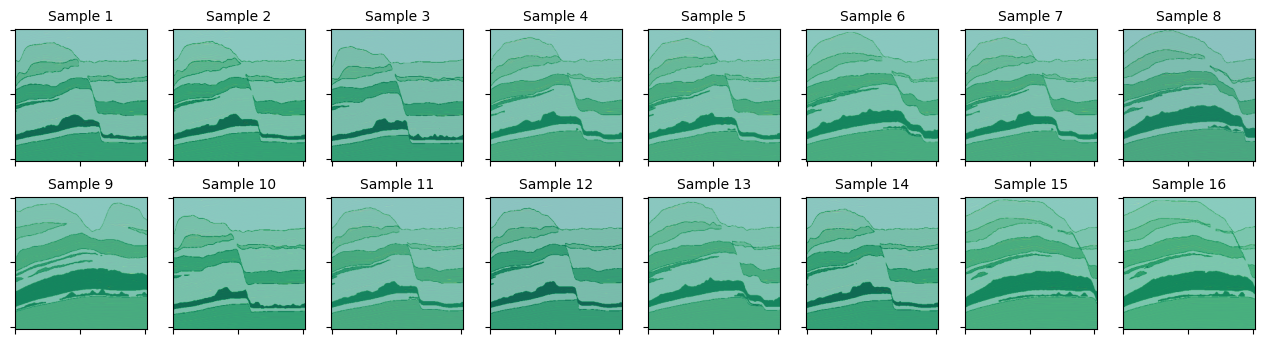

In [15]:

# Step 9: Visualize More Data from Dataset
max_images = 16
grid_width = 8
grid_height = max_images // grid_width
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width * 2, grid_height * 2))

for i in range(max_images):
    image, mask = train_dataset[i]
    image = np.transpose(image, (1, 2, 0))
    ax = axs[i // grid_width, i % grid_width]
    ax.imshow(image.squeeze(), cmap="Greys")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Greens")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(f"Sample {i+1}", fontsize=10)

# # Add color bar to indicate mask colors
# cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
# cbar = plt.colorbar(cm.ScalarMappable(cmap='Greens'), cax=cax)
# cbar.set_label('Mask Colors')

plt.show()

In [16]:
# Step 10: Define Model Architecture
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        )

        self.batch_norm = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm(x)
        return self.relu(x)

"""
Defines ChannelAttention class
"""
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction_rate=16):
        super(ChannelAttention, self).__init__()
        self.squeeze = nn.ModuleList([
            nn.AdaptiveAvgPool2d(1),
            nn.AdaptiveMaxPool2d(1)
        ])
        
        self.excitation = nn.Sequential(
            nn.Conv2d(in_channels=channels,
                      out_channels=channels // reduction_rate,
                      kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=channels // reduction_rate,
                      out_channels=channels,
                      kernel_size=1)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # perform squeeze with independent Pooling
        avg_feat = self.squeeze[0](x)
        max_feat = self.squeeze[1](x)
        # perform excitation with the same excitation sub-net
        avg_out = self.excitation(avg_feat)
        max_out = self.excitation(max_feat)
        # attention
        attention = self.sigmoid(avg_out + max_out)
        return attention * x
    
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=2,
            out_channels=1,
            kernel_size=kernel_size,
            padding=kernel_size // 2
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # mean on spatial dim
        avg_feat    = torch.mean(x, dim=1, keepdim=True)
        # max on spatial dim
        max_feat, _ = torch.max(x, dim=1, keepdim=True)
        feat = torch.cat([avg_feat, max_feat], dim=1)
        out_feat = self.conv(feat)
        attention = self.sigmoid(out_feat)
        return attention * x
    
class SpatialPath(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvBlock(kernel_size=3, stride=1, in_channels=3, out_channels=64)
        self.conv2 = ConvBlock(kernel_size=3, stride=1, in_channels=64, out_channels=128)
        self.conv3 = ConvBlock(kernel_size=3, stride=1, in_channels=128, out_channels=256)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

# class SpatialPath(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = ConvBlock(in_channels=3, out_channels=64)
#         self.c_attention1 = ChannelAttention(64)
#         self.s_attention1 = SpatialAttention()
#         self.conv2 = ConvBlock(in_channels=64, out_channels=128)
#         self.c_attention2 = ChannelAttention(128)
#         self.s_attention2 = SpatialAttention()
#         self.conv3 = ConvBlock(in_channels=128, out_channels=256)
#         self.c_attention3 = ChannelAttention(256)
#         self.s_attention3 = SpatialAttention()
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.c_attention1(x)
# #         x = self.s_attention1(x)
#         x = self.conv2(x)
#         x = self.c_attention2(x)
# #         x = self.s_attention2(x)
#         x = self.conv3(x)
#         x = self.c_attention3(x)
# #         x = self.s_attention3(x)
#         return x

class ContextPath(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features=models.resnet18(pretrained=pretrained)
        self.conv1=self.features.conv1
        self.bn1=self.features.bn1
        self.relu=self.features.relu
        self.max_pool=self.features.maxpool
        self.layer1=self.features.layer1
        self.layer2=self.features.layer2
        self.layer3=self.features.layer3
        self.layer4=self.features.layer4
        self.avg_pool=nn.AdaptiveAvgPool2d(output_size=(1,1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        feature1 = self.layer1(x)
        feature2 = self.layer2(feature1)
        feature3 = self.layer3(feature2)
        feature4 = self.layer4(feature3)

        tail = self.avg_pool(feature4)
        return feature3, feature4, tail

class AttentionRefinementModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.avg_pool=nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.conv=nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)
        self.bn=nn.BatchNorm2d(out_channels)
        self.sigmoid=nn.Sigmoid()
        self.in_channels=in_channels

    def forward(self, x_input):
        x = self.avg_pool(x_input)
        assert x.size(1) == self.in_channels,  'in_channels and out_channels should all be {}'.format(x.size(1))

        x = self.conv(x)
        x = self.bn(x)
        x = self.sigmoid(x)

        # Channel of x_input and x must be same
        return torch.mul(x_input, x)

class FeatureFusionModule(nn.Module):
    def __init__(self, num_classes, in_channels):
        super().__init__()
        self.in_channels=in_channels
        self.conv_block=ConvBlock(in_channels=in_channels, out_channels=num_classes, stride=1)
        self.conv1=nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)
        self.relu=nn.ReLU()
        self.conv2=nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)
        self.sigmoid=nn.Sigmoid()
        self.avg_pool=nn.AdaptiveAvgPool2d(output_size=(1,1))

    def forward(self, x_input_1, x_input_2):
        x = torch.cat((x_input_1, x_input_2), dim=1)
        assert self.in_channels == x.size(1), 'in_channels of ConvBlock should be {}'.format(x.size(1))
        feature = self.conv_block(x)

        # Apply above branch in feature
        x = self.avg_pool(feature)
        x = self.relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))

        # Multipy feature and x
        x = torch.mul(feature, x)

        # Combine feature and x
        return torch.add(feature, x)

In [17]:
# Step 11: Define BiSeNet Model
class BiSeNet(nn.Module):
    def __init__(self, num_classes, training=True):
        super().__init__()
        self.training = training
        self.spatial_path = SpatialPath()
        self.context_path = ContextPath()
        self.arm1 = AttentionRefinementModule(in_channels=256, out_channels=256)
        self.arm2 = AttentionRefinementModule(in_channels=512, out_channels=512)

        # Supervision for calculate loss
        self.supervision1 = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=1)
        self.supervision2 = nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1)

        # Feature fusion module
        self.ffm = FeatureFusionModule(num_classes=num_classes, in_channels=1024)

        # Final convolution
        self.conv = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)

    def forward(self, x_input):
        # Spatial path output
        sp_out = self.spatial_path(x_input)

        # Context path output`
        feature1, feature2, tail = self.context_path(x_input)

        # apply attention refinement module
        feature1, feature2 = self.arm1(feature1), self.arm2(feature2)

        # Combine output of lightweight model with tail
        feature2 = torch.mul(feature2, tail)

        # Up sampling
        size2d_out = sp_out.size()[-2:]
        feature1 = F.interpolate(feature1, size=size2d_out, mode='bilinear')
        feature2 = F.interpolate(feature2, size=size2d_out, mode='bilinear')
        context_out = torch.cat((feature1, feature2), dim=1)

        # Apply Feature Fusion Module
        combine_feature = self.ffm(sp_out, context_out)

        # Up sampling
        bisenet_out = F.interpolate(combine_feature, scale_factor=1, mode='bilinear')
        bisenet_out = self.conv(bisenet_out)

        # When training model
        if True:
            feature1_sup = self.supervision1(feature1)
            feature2_sup = self.supervision2(feature2)
            feature1_sup = F.interpolate(feature1_sup, size=x_input.size()[-2:], mode='bilinear')
            feature2_sup = F.interpolate(feature2_sup, size=x_input.size()[-2:], mode='bilinear')
            return bisenet_out, feature1_sup, feature2_sup
        return bisenet_out

In [18]:
# Step 14.1: Define Helper Functions

def reverse_one_hot(image):
    # Convert output of model to predicted class
    image = image.permute(0, 2, 3, 1)
    x = torch.argmax(image, dim=-1)
    return x

def compute_accuracy(pred, label):
    pred = pred.flatten()
    label = label.flatten()
    total = len(label)
    count = 0.0
    for i in range(total):
        if pred[i] == label[i]:
            count = count + 1.0
    return float(count) / float(total)

In [19]:
# Step 14.2: Get IoU Score
def fast_hist(a, b, n):
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

def per_class_iu(hist):
    epsilon = 1e-5
    return (np.diag(hist) + epsilon) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)

In [20]:
# Step 15: Get validate function
NUM_CLASSES=7
def val(model, dataloader):
    accuracy_arr = []

    hist = np.zeros((NUM_CLASSES, NUM_CLASSES))

    with torch.no_grad():
        model.eval()
        print('Starting validate')
        
        val_loss_record = []
        
        for i, (val_data, val_label) in enumerate(dataloader):
            val_data = val_data.cuda()
            val_label_cuda = val_label.cuda()
            # The output of model is (1, num_classes, W, H) => (num_classes, W, H)
            val_output, val_output_sup1, val_output_sup2 = model(val_data)
            
            val_loss1 = loss_func(val_output, val_label_cuda)
            val_loss2 = loss_func(val_output_sup1, val_label_cuda)
            val_loss3 = loss_func(val_output_sup2, val_label_cuda)

            # Combine 3 loss
            val_loss = val_loss1 + val_loss2 + val_loss3
            
            val_output = val_output.squeeze()
            val_output_sup1 = val_output_sup1.squeeze()
            val_output_sup2 = val_output_sup1.squeeze()
            # Convert the (num_classes, W, H) => (W, H) with one hot decoder
            val_output = reverse_one_hot(val_output)
            val_output = np.array(val_output.cpu())
            # Process label. Convert to (W, H) image
            val_label = val_label.squeeze()
            val_label = np.array(val_label.cpu())
            # Compute accuracy and iou
            accuracy = compute_accuracy(val_output, val_label)
            hist += fast_hist(val_label.flatten(), val_output.flatten(), NUM_CLASSES)
            # Append for calculate
            accuracy_arr.append(accuracy)
            val_loss_record.append(loss.item())
            
        val_loss_mean = np.mean(val_loss_record)
        miou_list = per_class_iu(hist)[:-1]
        mean_accuracy, mean_iou = np.mean(accuracy_arr), np.mean(miou_list)
        print('Mean validate loss: {} Mean validate IoU: {}'.format(val_loss_mean, mean_iou))
        return mean_accuracy, mean_iou, val_loss_mean

In [21]:
# Step 16.1: Create DataLoader for Training Dataset
dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
steps = len(train_dataset) // BATCH_SIZE
print(steps, "steps per epoch")

39 steps per epoch


In [22]:
# Step 16.3: Define model and training function, hyperparameters
EPOCHS = 200
LEARNING_RATE = 0.001
BATCH_SIZE = 16
CHECKPOINT_STEP = 2
VALIDATE_STEP = 1

model = BiSeNet(num_classes=NUM_CLASSES, training=True).to(device)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

loss_func = torch.nn.CrossEntropyLoss()

/home/sang/Desktop/venv39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sang/Desktop/venv39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
# Step 16.2: Model Training

# Loop for training
torch.cuda.empty_cache()

max_miou = 0
max_miou_epoch = 0

train_iou_hist = []
val_iou_hist = []

train_loss_hist = []
val_loss_hist = []

for epoch in range(EPOCHS):
    model.train()
    tq = tqdm(total=len(dataloader_train) * BATCH_SIZE)
    tq.set_description('Epoch {}/{}'.format(epoch + 1, EPOCHS))
    
    hist = np.zeros((NUM_CLASSES, NUM_CLASSES))
    loss_record = []

    for i, (data, label) in enumerate(dataloader_train):
        data = data.cuda()
        label = label.cuda()
        output, output_sup1, output_sup2 = model(data)
        loss1 = loss_func(output, label)
        loss2 = loss_func(output_sup1, label)
        loss3 = loss_func(output_sup2, label)

        # Combine 3 loss
        loss = loss1 + loss2 + loss3
        tq.update(BATCH_SIZE)
        tq.set_postfix(loss='%.6f' % loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_record.append(loss.item())
        
        output = reverse_one_hot(output)
        output = np.array(output.cpu())
        
        hist += fast_hist(label.flatten().detach().cpu().numpy(), output.flatten(), NUM_CLASSES)
        
    tq.close()
    loss_train_mean = np.mean(loss_record)
    miou_list = per_class_iu(hist)[:-1]
    mean_iou = np.mean(miou_list)
    
    train_iou_hist = train_iou_hist + [mean_iou]
    train_loss_hist = train_loss_hist + [loss_train_mean]
    
    print('loss for train : %f' % (loss_train_mean))
    print('IoU for train : %f' % (mean_iou))
    
    # Save checkpoint
    if epoch % CHECKPOINT_STEP == 0:
        torch.save(model.state_dict(), 'lastest_model_bisenet.pth')

    # Validate save best model
    # Save checkpoint
    if epoch % VALIDATE_STEP == 0:
        _, mean_iou, val_loss = val(model, dataloader_val)
        val_iou_hist = val_iou_hist + [mean_iou]
        val_loss_hist = val_loss_hist + [val_loss]
        if mean_iou > max_miou:
            max_miou = mean_iou
            max_miou_epoch = epoch + 1
            print('Save best model with mIoU = {}'.format(mean_iou))
            torch.save(model.state_dict(), 'best_model_bisenet.pth')
        else:
            print('Best mIoU: {} at epoch {}'.format(max_miou, max_miou_epoch))

Epoch 1/200: 100%|█████████████████████████████████████████████████████████| 624/624 [01:05<00:00,  9.51it/s, loss=2.748222]


loss for train : 3.574221
IoU for train : 0.329035
Starting validate
Mean validate loss: 2.7482223510742188 Mean validate IoU: 0.3802372835455506
Save best model with mIoU = 0.3802372835455506


Epoch 2/200: 100%|█████████████████████████████████████████████████████████| 624/624 [01:04<00:00,  9.63it/s, loss=2.058164]


loss for train : 2.377138
IoU for train : 0.488615
Starting validate
Mean validate loss: 2.05816388130188 Mean validate IoU: 0.4928315158590945
Save best model with mIoU = 0.4928315158590945


Epoch 3/200: 100%|█████████████████████████████████████████████████████████| 624/624 [01:05<00:00,  9.55it/s, loss=1.732357]


loss for train : 1.886781
IoU for train : 0.529012
Starting validate
Mean validate loss: 1.7323572635650635 Mean validate IoU: 0.5301767273757338
Save best model with mIoU = 0.5301767273757338


Epoch 4/200: 100%|█████████████████████████████████████████████████████████| 624/624 [00:57<00:00, 10.83it/s, loss=1.534726]


loss for train : 1.620955
IoU for train : 0.547619
Starting validate
Mean validate loss: 1.5347261428833008 Mean validate IoU: 0.5462424133501996
Save best model with mIoU = 0.5462424133501996


Epoch 5/200: 100%|█████████████████████████████████████████████████████████| 624/624 [00:59<00:00, 10.56it/s, loss=1.366812]


loss for train : 1.445517
IoU for train : 0.562725
Starting validate
Mean validate loss: 1.366811752319336 Mean validate IoU: 0.5575148345386908
Save best model with mIoU = 0.5575148345386908


Epoch 6/200: 100%|█████████████████████████████████████████████████████████| 624/624 [01:01<00:00, 10.11it/s, loss=1.317490]


loss for train : 1.333622
IoU for train : 0.572147
Starting validate
Mean validate loss: 1.3174899816513062 Mean validate IoU: 0.5462804893451778
Best mIoU: 0.5575148345386908 at epoch 5


Epoch 7/200: 100%|█████████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.27it/s, loss=1.252818]


loss for train : 1.264349
IoU for train : 0.579502
Starting validate
Mean validate loss: 1.2528175115585327 Mean validate IoU: 0.5763422956047023
Save best model with mIoU = 0.5763422956047023


Epoch 8/200: 100%|█████████████████████████████████████████████████████████| 624/624 [01:01<00:00, 10.21it/s, loss=1.170445]


loss for train : 1.205215
IoU for train : 0.630921
Starting validate
Mean validate loss: 1.1704447269439697 Mean validate IoU: 0.6760961595974385
Save best model with mIoU = 0.6760961595974385


Epoch 9/200: 100%|█████████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.31it/s, loss=1.114854]


loss for train : 1.149442
IoU for train : 0.697689
Starting validate
Mean validate loss: 1.1148537397384644 Mean validate IoU: 0.7031324773348301
Save best model with mIoU = 0.7031324773348301


Epoch 10/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.21it/s, loss=1.127423]


loss for train : 1.121234
IoU for train : 0.712718
Starting validate
Mean validate loss: 1.12742280960083 Mean validate IoU: 0.709608953443054
Save best model with mIoU = 0.709608953443054


Epoch 11/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.26it/s, loss=1.103752]


loss for train : 1.085188
IoU for train : 0.727598
Starting validate
Mean validate loss: 1.1037516593933105 Mean validate IoU: 0.7102752989563538
Save best model with mIoU = 0.7102752989563538


Epoch 12/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.17it/s, loss=1.097332]


loss for train : 1.069907
IoU for train : 0.734490
Starting validate
Mean validate loss: 1.0973318815231323 Mean validate IoU: 0.6007353977610128
Best mIoU: 0.7102752989563538 at epoch 11


Epoch 13/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.47it/s, loss=1.063077]


loss for train : 1.057432
IoU for train : 0.741032
Starting validate
Mean validate loss: 1.0630769729614258 Mean validate IoU: 0.7188582212957733
Save best model with mIoU = 0.7188582212957733


Epoch 14/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.38it/s, loss=1.018981]


loss for train : 1.033170
IoU for train : 0.750141
Starting validate
Mean validate loss: 1.018980622291565 Mean validate IoU: 0.7389694031793521
Save best model with mIoU = 0.7389694031793521


Epoch 15/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:56<00:00, 11.06it/s, loss=1.033491]


loss for train : 1.014095
IoU for train : 0.758841
Starting validate
Mean validate loss: 1.0334913730621338 Mean validate IoU: 0.73115882292426
Best mIoU: 0.7389694031793521 at epoch 14


Epoch 16/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.24it/s, loss=0.994375]


loss for train : 1.007831
IoU for train : 0.760229
Starting validate
Mean validate loss: 0.9943747520446777 Mean validate IoU: 0.7441510336283644
Save best model with mIoU = 0.7441510336283644


Epoch 17/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.67it/s, loss=0.989626]


loss for train : 0.998182
IoU for train : 0.766007
Starting validate
Mean validate loss: 0.9896262288093567 Mean validate IoU: 0.7486590877912667
Save best model with mIoU = 0.7486590877912667


Epoch 18/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:05<00:00,  9.55it/s, loss=0.989389]


loss for train : 0.985804
IoU for train : 0.771458
Starting validate
Mean validate loss: 0.9893885850906372 Mean validate IoU: 0.7588761447003805
Save best model with mIoU = 0.7588761447003805


Epoch 19/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.37it/s, loss=1.002467]


loss for train : 0.976967
IoU for train : 0.776153
Starting validate
Mean validate loss: 1.0024665594100952 Mean validate IoU: 0.7594650724938248
Save best model with mIoU = 0.7594650724938248


Epoch 20/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.18it/s, loss=0.971122]


loss for train : 0.974340
IoU for train : 0.776700
Starting validate
Mean validate loss: 0.9711217880249023 Mean validate IoU: 0.7665181054063055
Save best model with mIoU = 0.7665181054063055


Epoch 21/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:56<00:00, 11.07it/s, loss=0.945679]


loss for train : 0.969911
IoU for train : 0.779498
Starting validate
Mean validate loss: 0.9456790685653687 Mean validate IoU: 0.7682799405085355
Save best model with mIoU = 0.7682799405085355


Epoch 22/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.23it/s, loss=0.974924]


loss for train : 0.960719
IoU for train : 0.784035
Starting validate
Mean validate loss: 0.9749244451522827 Mean validate IoU: 0.75312725129869
Best mIoU: 0.7682799405085355 at epoch 21


Epoch 23/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.26it/s, loss=0.943455]


loss for train : 0.958997
IoU for train : 0.785062
Starting validate
Mean validate loss: 0.9434548020362854 Mean validate IoU: 0.7572738728732538
Best mIoU: 0.7682799405085355 at epoch 21


Epoch 24/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.36it/s, loss=0.930870]


loss for train : 0.950296
IoU for train : 0.789300
Starting validate
Mean validate loss: 0.9308699369430542 Mean validate IoU: 0.7594115339668644
Best mIoU: 0.7682799405085355 at epoch 21


Epoch 25/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:56<00:00, 11.02it/s, loss=0.952459]


loss for train : 0.946087
IoU for train : 0.792101
Starting validate
Mean validate loss: 0.9524591565132141 Mean validate IoU: 0.7729787155877387
Save best model with mIoU = 0.7729787155877387


Epoch 26/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:26<00:00,  7.17it/s, loss=0.974936]


loss for train : 0.943481
IoU for train : 0.793198
Starting validate
Mean validate loss: 0.9749363660812378 Mean validate IoU: 0.7707959761301901
Best mIoU: 0.7729787155877387 at epoch 25


Epoch 27/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:13<00:00,  8.53it/s, loss=0.930942]


loss for train : 0.940797
IoU for train : 0.794025
Starting validate
Mean validate loss: 0.9309422969818115 Mean validate IoU: 0.7750535692634246
Save best model with mIoU = 0.7750535692634246


Epoch 28/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:58<00:00, 10.59it/s, loss=0.932183]


loss for train : 0.934481
IoU for train : 0.798215
Starting validate
Mean validate loss: 0.9321826696395874 Mean validate IoU: 0.7762500074514557
Save best model with mIoU = 0.7762500074514557


Epoch 29/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.27it/s, loss=0.924537]


loss for train : 0.932468
IoU for train : 0.799849
Starting validate
Mean validate loss: 0.924536943435669 Mean validate IoU: 0.7806197385821037
Save best model with mIoU = 0.7806197385821037


Epoch 30/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.15it/s, loss=0.950674]


loss for train : 0.929783
IoU for train : 0.800362
Starting validate
Mean validate loss: 0.9506737589836121 Mean validate IoU: 0.7818568683363801
Save best model with mIoU = 0.7818568683363801


Epoch 31/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.16it/s, loss=0.916238]


loss for train : 0.924510
IoU for train : 0.804096
Starting validate
Mean validate loss: 0.9162381887435913 Mean validate IoU: 0.7824718968184886
Save best model with mIoU = 0.7824718968184886


Epoch 32/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.27it/s, loss=0.936652]


loss for train : 0.924979
IoU for train : 0.803569
Starting validate
Mean validate loss: 0.9366523623466492 Mean validate IoU: 0.7721596501643438
Best mIoU: 0.7824718968184886 at epoch 31


Epoch 33/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:59<00:00, 10.51it/s, loss=0.906228]


loss for train : 0.922217
IoU for train : 0.805461
Starting validate
Mean validate loss: 0.9062275886535645 Mean validate IoU: 0.7869460360838745
Save best model with mIoU = 0.7869460360838745


Epoch 34/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:06<00:00,  9.42it/s, loss=0.924186]


loss for train : 0.920127
IoU for train : 0.806869
Starting validate
Mean validate loss: 0.9241855144500732 Mean validate IoU: 0.783959063355013
Best mIoU: 0.7869460360838745 at epoch 33


Epoch 35/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.33it/s, loss=0.913651]


loss for train : 0.917275
IoU for train : 0.808574
Starting validate
Mean validate loss: 0.9136505126953125 Mean validate IoU: 0.7928065039551088
Save best model with mIoU = 0.7928065039551088


Epoch 36/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:08<00:00,  9.09it/s, loss=0.917248]


loss for train : 0.912748
IoU for train : 0.811521
Starting validate
Mean validate loss: 0.9172483682632446 Mean validate IoU: 0.778665618715393
Best mIoU: 0.7928065039551088 at epoch 35


Epoch 37/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:20<00:00,  7.76it/s, loss=0.899165]


loss for train : 0.912263
IoU for train : 0.811660
Starting validate
Mean validate loss: 0.8991647362709045 Mean validate IoU: 0.7830429774387503
Best mIoU: 0.7928065039551088 at epoch 35


Epoch 38/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:56<00:00, 10.97it/s, loss=0.911461]


loss for train : 0.909775
IoU for train : 0.813772
Starting validate
Mean validate loss: 0.9114611148834229 Mean validate IoU: 0.7918269040915402
Best mIoU: 0.7928065039551088 at epoch 35


Epoch 39/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.28it/s, loss=0.906672]


loss for train : 0.908381
IoU for train : 0.815324
Starting validate
Mean validate loss: 0.9066717624664307 Mean validate IoU: 0.7943914529214696
Save best model with mIoU = 0.7943914529214696


Epoch 40/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.48it/s, loss=0.909241]


loss for train : 0.906390
IoU for train : 0.815535
Starting validate
Mean validate loss: 0.9092410802841187 Mean validate IoU: 0.7848772871224917
Best mIoU: 0.7943914529214696 at epoch 39


Epoch 41/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:02<00:00,  9.94it/s, loss=0.893619]


loss for train : 0.905349
IoU for train : 0.816492
Starting validate
Mean validate loss: 0.8936187028884888 Mean validate IoU: 0.7799022061227516
Best mIoU: 0.7943914529214696 at epoch 39


Epoch 42/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:01<00:00, 10.14it/s, loss=0.887129]


loss for train : 0.901572
IoU for train : 0.819355
Starting validate
Mean validate loss: 0.8871288299560547 Mean validate IoU: 0.7833137185904474
Best mIoU: 0.7943914529214696 at epoch 39


Epoch 43/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:04<00:00,  9.72it/s, loss=0.885587]


loss for train : 0.901384
IoU for train : 0.820425
Starting validate
Mean validate loss: 0.8855866193771362 Mean validate IoU: 0.7854925718945992
Best mIoU: 0.7943914529214696 at epoch 39


Epoch 44/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:03<00:00,  9.79it/s, loss=0.914084]


loss for train : 0.905512
IoU for train : 0.816606
Starting validate
Mean validate loss: 0.9140839576721191 Mean validate IoU: 0.7774052943797995
Best mIoU: 0.7943914529214696 at epoch 39


Epoch 45/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:05<00:00,  9.53it/s, loss=0.885420]


loss for train : 0.902407
IoU for train : 0.818748
Starting validate
Mean validate loss: 0.8854199051856995 Mean validate IoU: 0.7906623275464136
Best mIoU: 0.7943914529214696 at epoch 39


Epoch 46/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:04<00:00,  9.61it/s, loss=0.905741]


loss for train : 0.896965
IoU for train : 0.823308
Starting validate
Mean validate loss: 0.9057410359382629 Mean validate IoU: 0.7944895775684265
Save best model with mIoU = 0.7944895775684265


Epoch 47/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:04<00:00,  9.65it/s, loss=0.877023]


loss for train : 0.897846
IoU for train : 0.821965
Starting validate
Mean validate loss: 0.8770225644111633 Mean validate IoU: 0.7964836282932987
Save best model with mIoU = 0.7964836282932987


Epoch 48/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:02<00:00, 10.01it/s, loss=0.887677]


loss for train : 0.892704
IoU for train : 0.825992
Starting validate
Mean validate loss: 0.8876773118972778 Mean validate IoU: 0.8029398204190987
Save best model with mIoU = 0.8029398204190987


Epoch 49/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:02<00:00,  9.91it/s, loss=0.879938]


loss for train : 0.893017
IoU for train : 0.825369
Starting validate
Mean validate loss: 0.8799384832382202 Mean validate IoU: 0.7930086662500195
Best mIoU: 0.8029398204190987 at epoch 48


Epoch 50/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:03<00:00,  9.88it/s, loss=0.872397]


loss for train : 0.891146
IoU for train : 0.826687
Starting validate
Mean validate loss: 0.8723971247673035 Mean validate IoU: 0.8044931984436143
Save best model with mIoU = 0.8044931984436143


Epoch 51/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:02<00:00, 10.03it/s, loss=0.888409]


loss for train : 0.887163
IoU for train : 0.830063
Starting validate
Mean validate loss: 0.8884090781211853 Mean validate IoU: 0.7993972766521308
Best mIoU: 0.8044931984436143 at epoch 50


Epoch 52/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.28it/s, loss=0.900239]


loss for train : 0.888962
IoU for train : 0.828385
Starting validate
Mean validate loss: 0.9002389907836914 Mean validate IoU: 0.795291116262737
Best mIoU: 0.8044931984436143 at epoch 50


Epoch 53/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:01<00:00, 10.22it/s, loss=0.885797]


loss for train : 0.885689
IoU for train : 0.831064
Starting validate
Mean validate loss: 0.885797381401062 Mean validate IoU: 0.8004341466226158
Best mIoU: 0.8044931984436143 at epoch 50


Epoch 54/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:56<00:00, 11.03it/s, loss=0.889164]


loss for train : 0.884977
IoU for train : 0.831368
Starting validate
Mean validate loss: 0.8891644477844238 Mean validate IoU: 0.8049442298081306
Save best model with mIoU = 0.8049442298081306


Epoch 55/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:06<00:00,  9.34it/s, loss=0.863827]


loss for train : 0.886717
IoU for train : 0.830333
Starting validate
Mean validate loss: 0.8638270497322083 Mean validate IoU: 0.7793101102026219
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 56/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:07<00:00,  9.19it/s, loss=0.879294]


loss for train : 0.883421
IoU for train : 0.832749
Starting validate
Mean validate loss: 0.8792935609817505 Mean validate IoU: 0.7974274212083255
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 57/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:08<00:00,  9.15it/s, loss=0.882974]


loss for train : 0.883975
IoU for train : 0.832247
Starting validate
Mean validate loss: 0.8829742074012756 Mean validate IoU: 0.804158171365339
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 58/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:08<00:00,  9.06it/s, loss=0.902836]


loss for train : 0.884360
IoU for train : 0.832550
Starting validate
Mean validate loss: 0.9028355479240417 Mean validate IoU: 0.8011241802663474
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 59/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:04<00:00,  9.62it/s, loss=0.856124]


loss for train : 0.880827
IoU for train : 0.835452
Starting validate
Mean validate loss: 0.8561243414878845 Mean validate IoU: 0.7996721961063112
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 60/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:04<00:00,  9.66it/s, loss=0.863996]


loss for train : 0.880633
IoU for train : 0.835362
Starting validate
Mean validate loss: 0.8639963865280151 Mean validate IoU: 0.7955946725424691
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 61/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:04<00:00,  9.73it/s, loss=0.871109]


loss for train : 0.883907
IoU for train : 0.833189
Starting validate
Mean validate loss: 0.8711087703704834 Mean validate IoU: 0.793065062621555
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 62/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:06<00:00,  9.41it/s, loss=0.853402]


loss for train : 0.880565
IoU for train : 0.835415
Starting validate
Mean validate loss: 0.8534020781517029 Mean validate IoU: 0.7974391747898831
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 63/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:56<00:00, 11.13it/s, loss=0.876186]


loss for train : 0.876351
IoU for train : 0.838420
Starting validate
Mean validate loss: 0.8761861324310303 Mean validate IoU: 0.7964954902840523
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 64/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:56<00:00, 10.97it/s, loss=0.878506]


loss for train : 0.877367
IoU for train : 0.837623
Starting validate
Mean validate loss: 0.8785055875778198 Mean validate IoU: 0.792012670170522
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 65/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:56<00:00, 10.99it/s, loss=0.882065]


loss for train : 0.874254
IoU for train : 0.840445
Starting validate
Mean validate loss: 0.8820654153823853 Mean validate IoU: 0.7885226983720734
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 66/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.18it/s, loss=0.862940]


loss for train : 0.874313
IoU for train : 0.839915
Starting validate
Mean validate loss: 0.8629404902458191 Mean validate IoU: 0.8047106193387066
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 67/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.21it/s, loss=0.891155]


loss for train : 0.873911
IoU for train : 0.840583
Starting validate
Mean validate loss: 0.891154944896698 Mean validate IoU: 0.790936535435533
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 68/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:57<00:00, 10.90it/s, loss=0.890501]


loss for train : 0.873427
IoU for train : 0.841275
Starting validate
Mean validate loss: 0.8905009031295776 Mean validate IoU: 0.7951339170115834
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 69/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.22it/s, loss=0.883722]


loss for train : 0.872546
IoU for train : 0.841587
Starting validate
Mean validate loss: 0.883722186088562 Mean validate IoU: 0.7881228618993705
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 70/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:56<00:00, 11.14it/s, loss=0.915775]


loss for train : 0.877046
IoU for train : 0.837925
Starting validate
Mean validate loss: 0.9157745242118835 Mean validate IoU: 0.7963217525846146
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 71/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.21it/s, loss=0.874525]


loss for train : 0.873587
IoU for train : 0.841714
Starting validate
Mean validate loss: 0.8745248317718506 Mean validate IoU: 0.7964924756721389
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 72/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.17it/s, loss=0.890594]


loss for train : 0.869651
IoU for train : 0.844304
Starting validate
Mean validate loss: 0.8905938863754272 Mean validate IoU: 0.796200385106546
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 73/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:56<00:00, 11.08it/s, loss=0.863653]


loss for train : 0.869111
IoU for train : 0.844155
Starting validate
Mean validate loss: 0.8636525869369507 Mean validate IoU: 0.8024551330017854
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 74/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.17it/s, loss=0.853255]


loss for train : 0.867358
IoU for train : 0.845690
Starting validate
Mean validate loss: 0.8532546758651733 Mean validate IoU: 0.7983007509294877
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 75/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.31it/s, loss=0.866430]


loss for train : 0.867556
IoU for train : 0.845820
Starting validate
Mean validate loss: 0.8664298057556152 Mean validate IoU: 0.7986781880706421
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 76/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.30it/s, loss=0.895851]


loss for train : 0.868448
IoU for train : 0.844876
Starting validate
Mean validate loss: 0.8958508968353271 Mean validate IoU: 0.7861723362618673
Best mIoU: 0.8049442298081306 at epoch 54


Epoch 77/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:56<00:00, 10.99it/s, loss=0.849998]


loss for train : 0.867548
IoU for train : 0.845724
Starting validate
Mean validate loss: 0.8499984741210938 Mean validate IoU: 0.8114845069924393
Save best model with mIoU = 0.8114845069924393


Epoch 78/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.22it/s, loss=0.849333]


loss for train : 0.867051
IoU for train : 0.846554
Starting validate
Mean validate loss: 0.8493331670761108 Mean validate IoU: 0.7853194430301577
Best mIoU: 0.8114845069924393 at epoch 77


Epoch 79/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:52<00:00, 11.85it/s, loss=0.890657]


loss for train : 0.865953
IoU for train : 0.847417
Starting validate
Mean validate loss: 0.8906569480895996 Mean validate IoU: 0.7878803673427571
Best mIoU: 0.8114845069924393 at epoch 77


Epoch 80/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.47it/s, loss=0.856220]


loss for train : 0.868408
IoU for train : 0.844314
Starting validate
Mean validate loss: 0.8562202453613281 Mean validate IoU: 0.813948761573401
Save best model with mIoU = 0.813948761573401


Epoch 81/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:52<00:00, 11.94it/s, loss=0.866509]


loss for train : 0.867106
IoU for train : 0.846603
Starting validate
Mean validate loss: 0.8665088415145874 Mean validate IoU: 0.7994282675306583
Best mIoU: 0.813948761573401 at epoch 80


Epoch 82/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:56<00:00, 10.96it/s, loss=0.861716]


loss for train : 0.864988
IoU for train : 0.848600
Starting validate
Mean validate loss: 0.8617160320281982 Mean validate IoU: 0.8072832826893462
Best mIoU: 0.813948761573401 at epoch 80


Epoch 83/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.02it/s, loss=0.845025]


loss for train : 0.863189
IoU for train : 0.850305
Starting validate
Mean validate loss: 0.8450249433517456 Mean validate IoU: 0.7988862930652557
Best mIoU: 0.813948761573401 at epoch 80


Epoch 84/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.33it/s, loss=0.857588]


loss for train : 0.863958
IoU for train : 0.848903
Starting validate
Mean validate loss: 0.8575879335403442 Mean validate IoU: 0.8000584426015412
Best mIoU: 0.813948761573401 at epoch 80


Epoch 85/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:09<00:00,  9.04it/s, loss=0.827343]


loss for train : 0.863481
IoU for train : 0.849300
Starting validate
Mean validate loss: 0.8273431062698364 Mean validate IoU: 0.8110274749788329
Best mIoU: 0.813948761573401 at epoch 80


Epoch 86/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:15<00:00,  8.23it/s, loss=0.820390]


loss for train : 0.861459
IoU for train : 0.851941
Starting validate
Mean validate loss: 0.8203903436660767 Mean validate IoU: 0.8032834781224117
Best mIoU: 0.813948761573401 at epoch 80


Epoch 87/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:13<00:00,  8.52it/s, loss=0.868507]


loss for train : 0.864817
IoU for train : 0.850296
Starting validate
Mean validate loss: 0.868506908416748 Mean validate IoU: 0.6815387661422451
Best mIoU: 0.813948761573401 at epoch 80


Epoch 88/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:12<00:00,  8.64it/s, loss=0.929204]


loss for train : 0.978755
IoU for train : 0.800934
Starting validate
Mean validate loss: 0.9292035102844238 Mean validate IoU: 0.7362972834578386
Best mIoU: 0.813948761573401 at epoch 80


Epoch 89/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:09<00:00,  8.96it/s, loss=0.925499]


loss for train : 0.922224
IoU for train : 0.821981
Starting validate
Mean validate loss: 0.9254987239837646 Mean validate IoU: 0.7072250932325533
Best mIoU: 0.813948761573401 at epoch 80


Epoch 90/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:14<00:00,  8.40it/s, loss=0.884072]


loss for train : 0.911057
IoU for train : 0.828229
Starting validate
Mean validate loss: 0.8840722441673279 Mean validate IoU: 0.8030878161847937
Best mIoU: 0.813948761573401 at epoch 80


Epoch 91/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:14<00:00,  8.38it/s, loss=0.868947]


loss for train : 0.887438
IoU for train : 0.838850
Starting validate
Mean validate loss: 0.868947446346283 Mean validate IoU: 0.7759318799463698
Best mIoU: 0.813948761573401 at epoch 80


Epoch 92/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:15<00:00,  8.25it/s, loss=0.885917]


loss for train : 0.879642
IoU for train : 0.842508
Starting validate
Mean validate loss: 0.8859167695045471 Mean validate IoU: 0.7879195386249448
Best mIoU: 0.813948761573401 at epoch 80


Epoch 93/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:12<00:00,  8.66it/s, loss=0.883384]


loss for train : 0.872047
IoU for train : 0.846281
Starting validate
Mean validate loss: 0.8833844661712646 Mean validate IoU: 0.7738421229681761
Best mIoU: 0.813948761573401 at epoch 80


Epoch 94/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:14<00:00,  8.35it/s, loss=0.888451]


loss for train : 0.869400
IoU for train : 0.847762
Starting validate
Mean validate loss: 0.8884505033493042 Mean validate IoU: 0.805583290515878
Best mIoU: 0.813948761573401 at epoch 80


Epoch 95/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:04<00:00,  9.71it/s, loss=0.857579]


loss for train : 0.867537
IoU for train : 0.848707
Starting validate
Mean validate loss: 0.8575785160064697 Mean validate IoU: 0.7947995858329192
Best mIoU: 0.813948761573401 at epoch 80


Epoch 96/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.45it/s, loss=0.853592]


loss for train : 0.865354
IoU for train : 0.850800
Starting validate
Mean validate loss: 0.853592038154602 Mean validate IoU: 0.8067206430354922
Best mIoU: 0.813948761573401 at epoch 80


Epoch 97/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:01<00:00, 10.19it/s, loss=0.864942]


loss for train : 0.863750
IoU for train : 0.851417
Starting validate
Mean validate loss: 0.864942193031311 Mean validate IoU: 0.7927120266362916
Best mIoU: 0.813948761573401 at epoch 80


Epoch 98/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:07<00:00,  9.29it/s, loss=0.864825]


loss for train : 0.861879
IoU for train : 0.852877
Starting validate
Mean validate loss: 0.8648248910903931 Mean validate IoU: 0.8123574379846191
Best mIoU: 0.813948761573401 at epoch 80


Epoch 99/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:02<00:00,  9.91it/s, loss=0.847864]


loss for train : 0.860293
IoU for train : 0.854185
Starting validate
Mean validate loss: 0.8478638529777527 Mean validate IoU: 0.8135198817550107
Best mIoU: 0.813948761573401 at epoch 80


Epoch 100/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:04<00:00,  9.73it/s, loss=0.859197]


loss for train : 0.860280
IoU for train : 0.853620
Starting validate
Mean validate loss: 0.8591970205307007 Mean validate IoU: 0.8032793675557124
Best mIoU: 0.813948761573401 at epoch 80


Epoch 101/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:02<00:00,  9.96it/s, loss=0.843403]


loss for train : 0.860262
IoU for train : 0.853421
Starting validate
Mean validate loss: 0.8434031009674072 Mean validate IoU: 0.7785536056187295
Best mIoU: 0.813948761573401 at epoch 80


Epoch 102/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:07<00:00,  9.28it/s, loss=0.872761]


loss for train : 0.858521
IoU for train : 0.854609
Starting validate
Mean validate loss: 0.8727613687515259 Mean validate IoU: 0.805487076139756
Best mIoU: 0.813948761573401 at epoch 80


Epoch 103/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:10<00:00,  8.79it/s, loss=0.850300]


loss for train : 0.858469
IoU for train : 0.855015
Starting validate
Mean validate loss: 0.8503003716468811 Mean validate IoU: 0.8127791074614202
Best mIoU: 0.813948761573401 at epoch 80


Epoch 104/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:15<00:00,  8.22it/s, loss=0.849068]


loss for train : 0.858016
IoU for train : 0.855937
Starting validate
Mean validate loss: 0.8490680456161499 Mean validate IoU: 0.8082397370706573
Best mIoU: 0.813948761573401 at epoch 80


Epoch 105/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:08<00:00,  9.11it/s, loss=0.879876]


loss for train : 0.856348
IoU for train : 0.856685
Starting validate
Mean validate loss: 0.8798761963844299 Mean validate IoU: 0.8142048674523235
Save best model with mIoU = 0.8142048674523235


Epoch 106/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:07<00:00,  9.28it/s, loss=0.847681]


loss for train : 0.856064
IoU for train : 0.857403
Starting validate
Mean validate loss: 0.8476813435554504 Mean validate IoU: 0.8069360525303545
Best mIoU: 0.8142048674523235 at epoch 105


Epoch 107/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:09<00:00,  8.94it/s, loss=0.861334]


loss for train : 0.855947
IoU for train : 0.856868
Starting validate
Mean validate loss: 0.8613344430923462 Mean validate IoU: 0.8079392670415949
Best mIoU: 0.8142048674523235 at epoch 105


Epoch 108/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:08<00:00,  9.17it/s, loss=0.880164]


loss for train : 0.855946
IoU for train : 0.856636
Starting validate
Mean validate loss: 0.8801640868186951 Mean validate IoU: 0.7985548656391317
Best mIoU: 0.8142048674523235 at epoch 105


Epoch 109/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:57<00:00, 10.76it/s, loss=0.837042]


loss for train : 0.857777
IoU for train : 0.855490
Starting validate
Mean validate loss: 0.8370420932769775 Mean validate IoU: 0.7978821174748135
Best mIoU: 0.8142048674523235 at epoch 105


Epoch 110/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.27it/s, loss=0.850636]


loss for train : 0.860755
IoU for train : 0.853316
Starting validate
Mean validate loss: 0.8506364822387695 Mean validate IoU: 0.8031614718788309
Best mIoU: 0.8142048674523235 at epoch 105


Epoch 111/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.26it/s, loss=0.879074]


loss for train : 0.854536
IoU for train : 0.858319
Starting validate
Mean validate loss: 0.879074215888977 Mean validate IoU: 0.8092821019904096
Best mIoU: 0.8142048674523235 at epoch 105


Epoch 112/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:58<00:00, 10.64it/s, loss=0.856660]


loss for train : 0.853069
IoU for train : 0.859795
Starting validate
Mean validate loss: 0.8566602468490601 Mean validate IoU: 0.8046068668084473
Best mIoU: 0.8142048674523235 at epoch 105


Epoch 113/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.37it/s, loss=0.859574]


loss for train : 0.854063
IoU for train : 0.858784
Starting validate
Mean validate loss: 0.8595741391181946 Mean validate IoU: 0.8130601010864279
Best mIoU: 0.8142048674523235 at epoch 105


Epoch 114/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:09<00:00,  9.00it/s, loss=0.846943]


loss for train : 0.852948
IoU for train : 0.860256
Starting validate
Mean validate loss: 0.8469432592391968 Mean validate IoU: 0.8036827982557909
Best mIoU: 0.8142048674523235 at epoch 105


Epoch 115/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:08<00:00,  9.06it/s, loss=0.856089]


loss for train : 0.852103
IoU for train : 0.860055
Starting validate
Mean validate loss: 0.8560886383056641 Mean validate IoU: 0.8028215061893661
Best mIoU: 0.8142048674523235 at epoch 105


Epoch 116/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:08<00:00,  9.07it/s, loss=0.855727]


loss for train : 0.851853
IoU for train : 0.860776
Starting validate
Mean validate loss: 0.8557270765304565 Mean validate IoU: 0.8100465939371934
Best mIoU: 0.8142048674523235 at epoch 105


Epoch 117/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.26it/s, loss=0.863374]


loss for train : 0.851569
IoU for train : 0.860764
Starting validate
Mean validate loss: 0.8633743524551392 Mean validate IoU: 0.8055880909037509
Best mIoU: 0.8142048674523235 at epoch 105


Epoch 118/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:09<00:00,  9.01it/s, loss=0.863879]


loss for train : 0.852147
IoU for train : 0.860225
Starting validate
Mean validate loss: 0.8638787269592285 Mean validate IoU: 0.7973693495502786
Best mIoU: 0.8142048674523235 at epoch 105


Epoch 119/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:06<00:00,  9.45it/s, loss=0.815104]


loss for train : 0.852360
IoU for train : 0.860393
Starting validate
Mean validate loss: 0.8151041865348816 Mean validate IoU: 0.7962257870088849
Best mIoU: 0.8142048674523235 at epoch 105


Epoch 120/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:34<00:00,  6.60it/s, loss=0.835231]


loss for train : 0.852059
IoU for train : 0.861095
Starting validate
Mean validate loss: 0.8352309465408325 Mean validate IoU: 0.8159465216236108
Save best model with mIoU = 0.8159465216236108


Epoch 121/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:13<00:00,  8.54it/s, loss=0.845405]


loss for train : 0.849612
IoU for train : 0.862967
Starting validate
Mean validate loss: 0.8454053997993469 Mean validate IoU: 0.8119916451043493
Best mIoU: 0.8159465216236108 at epoch 120


Epoch 122/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:15<00:00,  8.24it/s, loss=0.857911]


loss for train : 0.851836
IoU for train : 0.860372
Starting validate
Mean validate loss: 0.8579106330871582 Mean validate IoU: 0.8019492074893321
Best mIoU: 0.8159465216236108 at epoch 120


Epoch 123/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:05<00:00,  9.56it/s, loss=0.864629]


loss for train : 0.850018
IoU for train : 0.861927
Starting validate
Mean validate loss: 0.8646285533905029 Mean validate IoU: 0.8032580350556837
Best mIoU: 0.8159465216236108 at epoch 120


Epoch 124/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:59<00:00, 10.50it/s, loss=0.841819]


loss for train : 0.850404
IoU for train : 0.862042
Starting validate
Mean validate loss: 0.8418188095092773 Mean validate IoU: 0.8036438303906488
Best mIoU: 0.8159465216236108 at epoch 120


Epoch 125/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.36it/s, loss=0.845983]


loss for train : 0.847369
IoU for train : 0.864907
Starting validate
Mean validate loss: 0.8459830284118652 Mean validate IoU: 0.8191415287415942
Save best model with mIoU = 0.8191415287415942


Epoch 126/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:01<00:00, 10.19it/s, loss=0.834277]


loss for train : 0.846934
IoU for train : 0.865230
Starting validate
Mean validate loss: 0.834277331829071 Mean validate IoU: 0.8199975442841431
Save best model with mIoU = 0.8199975442841431


Epoch 127/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.25it/s, loss=0.852438]


loss for train : 0.846675
IoU for train : 0.865789
Starting validate
Mean validate loss: 0.8524379134178162 Mean validate IoU: 0.8118863752799462
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 128/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:01<00:00, 10.19it/s, loss=0.846700]


loss for train : 0.846355
IoU for train : 0.866190
Starting validate
Mean validate loss: 0.8467000722885132 Mean validate IoU: 0.8024583592989503
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 129/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.25it/s, loss=0.853870]


loss for train : 0.847552
IoU for train : 0.865003
Starting validate
Mean validate loss: 0.8538697957992554 Mean validate IoU: 0.8047183835769167
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 130/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:01<00:00, 10.08it/s, loss=0.870351]


loss for train : 0.847431
IoU for train : 0.864762
Starting validate
Mean validate loss: 0.8703514933586121 Mean validate IoU: 0.8157146536054886
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 131/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:02<00:00, 10.02it/s, loss=0.864381]


loss for train : 0.847436
IoU for train : 0.864165
Starting validate
Mean validate loss: 0.8643806576728821 Mean validate IoU: 0.7959505146152496
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 132/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.27it/s, loss=0.858039]


loss for train : 0.847219
IoU for train : 0.864700
Starting validate
Mean validate loss: 0.8580392599105835 Mean validate IoU: 0.8125649237176007
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 133/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.25it/s, loss=0.833324]


loss for train : 0.846529
IoU for train : 0.865543
Starting validate
Mean validate loss: 0.8333241939544678 Mean validate IoU: 0.7977237713316304
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 134/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:01<00:00, 10.21it/s, loss=0.865145]


loss for train : 0.846469
IoU for train : 0.866197
Starting validate
Mean validate loss: 0.8651453256607056 Mean validate IoU: 0.803991107903439
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 135/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:01<00:00, 10.21it/s, loss=0.862282]


loss for train : 0.845128
IoU for train : 0.866959
Starting validate
Mean validate loss: 0.8622819185256958 Mean validate IoU: 0.818419369324769
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 136/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.29it/s, loss=0.845860]


loss for train : 0.845450
IoU for train : 0.866497
Starting validate
Mean validate loss: 0.8458601236343384 Mean validate IoU: 0.8107004641984972
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 137/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:59<00:00, 10.46it/s, loss=0.826508]


loss for train : 0.844993
IoU for train : 0.867157
Starting validate
Mean validate loss: 0.8265079855918884 Mean validate IoU: 0.8104537141599013
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 138/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:01<00:00, 10.23it/s, loss=0.834242]


loss for train : 0.843971
IoU for train : 0.868530
Starting validate
Mean validate loss: 0.8342418670654297 Mean validate IoU: 0.8105633608311442
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 139/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:57<00:00, 10.78it/s, loss=0.859752]


loss for train : 0.844879
IoU for train : 0.866662
Starting validate
Mean validate loss: 0.8597522974014282 Mean validate IoU: 0.8098357696558205
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 140/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:05<00:00,  9.46it/s, loss=0.844026]


loss for train : 0.844238
IoU for train : 0.867715
Starting validate
Mean validate loss: 0.8440256118774414 Mean validate IoU: 0.8122143305487777
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 141/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:14<00:00,  8.37it/s, loss=0.846034]


loss for train : 0.844669
IoU for train : 0.867704
Starting validate
Mean validate loss: 0.8460338115692139 Mean validate IoU: 0.8075282173653466
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 142/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:17<00:00,  8.08it/s, loss=0.857423]


loss for train : 0.844196
IoU for train : 0.868255
Starting validate
Mean validate loss: 0.8574225306510925 Mean validate IoU: 0.8042746490376728
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 143/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:15<00:00,  8.25it/s, loss=0.838699]


loss for train : 0.843962
IoU for train : 0.867921
Starting validate
Mean validate loss: 0.8386992812156677 Mean validate IoU: 0.8002775153402534
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 144/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.27it/s, loss=0.852430]


loss for train : 0.842918
IoU for train : 0.869147
Starting validate
Mean validate loss: 0.8524297475814819 Mean validate IoU: 0.8059934138823307
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 145/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:58<00:00, 10.60it/s, loss=0.857333]


loss for train : 0.844253
IoU for train : 0.867836
Starting validate
Mean validate loss: 0.8573333024978638 Mean validate IoU: 0.8121136695794698
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 146/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:03<00:00,  9.87it/s, loss=0.847818]


loss for train : 0.842477
IoU for train : 0.870090
Starting validate
Mean validate loss: 0.8478181958198547 Mean validate IoU: 0.7976183208987248
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 147/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:10<00:00,  8.91it/s, loss=0.846878]


loss for train : 0.845738
IoU for train : 0.866429
Starting validate
Mean validate loss: 0.846878170967102 Mean validate IoU: 0.8029173649194378
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 148/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:01<00:00, 10.21it/s, loss=0.863188]


loss for train : 0.843054
IoU for train : 0.869654
Starting validate
Mean validate loss: 0.8631882071495056 Mean validate IoU: 0.8071456088587037
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 149/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.23it/s, loss=0.849881]


loss for train : 0.843385
IoU for train : 0.868493
Starting validate
Mean validate loss: 0.8498813509941101 Mean validate IoU: 0.819900698101049
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 150/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:02<00:00,  9.95it/s, loss=0.847636]


loss for train : 0.841888
IoU for train : 0.870208
Starting validate
Mean validate loss: 0.8476357460021973 Mean validate IoU: 0.8012451746383191
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 151/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.32it/s, loss=0.828206]


loss for train : 0.840772
IoU for train : 0.871625
Starting validate
Mean validate loss: 0.8282055854797363 Mean validate IoU: 0.7966263302807763
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 152/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.26it/s, loss=0.842195]


loss for train : 0.838768
IoU for train : 0.873454
Starting validate
Mean validate loss: 0.8421952724456787 Mean validate IoU: 0.8021708119567176
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 153/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:59<00:00, 10.55it/s, loss=0.860914]


loss for train : 0.840942
IoU for train : 0.871276
Starting validate
Mean validate loss: 0.8609142899513245 Mean validate IoU: 0.8061303869839477
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 154/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:59<00:00, 10.46it/s, loss=0.836935]


loss for train : 0.845291
IoU for train : 0.866862
Starting validate
Mean validate loss: 0.83693528175354 Mean validate IoU: 0.8072639038126886
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 155/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.33it/s, loss=0.855988]


loss for train : 0.843955
IoU for train : 0.868440
Starting validate
Mean validate loss: 0.8559878468513489 Mean validate IoU: 0.790682005658439
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 156/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.32it/s, loss=0.855358]


loss for train : 0.844817
IoU for train : 0.867767
Starting validate
Mean validate loss: 0.8553578853607178 Mean validate IoU: 0.7862512456288471
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 157/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:01<00:00, 10.23it/s, loss=0.846258]


loss for train : 0.841436
IoU for train : 0.871220
Starting validate
Mean validate loss: 0.8462575674057007 Mean validate IoU: 0.8114579340986738
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 158/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:59<00:00, 10.57it/s, loss=0.849737]


loss for train : 0.838567
IoU for train : 0.873874
Starting validate
Mean validate loss: 0.8497369289398193 Mean validate IoU: 0.8150778324886833
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 159/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:59<00:00, 10.52it/s, loss=0.827421]


loss for train : 0.840329
IoU for train : 0.871373
Starting validate
Mean validate loss: 0.8274208307266235 Mean validate IoU: 0.7962499500725899
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 160/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.30it/s, loss=0.859298]


loss for train : 0.838139
IoU for train : 0.874048
Starting validate
Mean validate loss: 0.8592977523803711 Mean validate IoU: 0.7984890038598597
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 161/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:01<00:00, 10.18it/s, loss=0.859590]


loss for train : 0.840014
IoU for train : 0.872211
Starting validate
Mean validate loss: 0.8595895767211914 Mean validate IoU: 0.8123496935206359
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 162/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.25it/s, loss=0.849468]


loss for train : 0.839046
IoU for train : 0.872709
Starting validate
Mean validate loss: 0.8494676947593689 Mean validate IoU: 0.7803478446348603
Best mIoU: 0.8199975442841431 at epoch 126


Epoch 163/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.36it/s, loss=0.844987]


loss for train : 0.839515
IoU for train : 0.872382
Starting validate
Mean validate loss: 0.8449867367744446 Mean validate IoU: 0.8249474977192822
Save best model with mIoU = 0.8249474977192822


Epoch 164/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.35it/s, loss=0.851664]


loss for train : 0.838804
IoU for train : 0.873354
Starting validate
Mean validate loss: 0.8516637682914734 Mean validate IoU: 0.8242007138132316
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 165/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:12<00:00,  8.60it/s, loss=0.831667]


loss for train : 0.839380
IoU for train : 0.872813
Starting validate
Mean validate loss: 0.8316665291786194 Mean validate IoU: 0.8042270308567109
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 166/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:16<00:00,  8.13it/s, loss=0.832898]


loss for train : 0.837246
IoU for train : 0.874793
Starting validate
Mean validate loss: 0.8328980207443237 Mean validate IoU: 0.8166234935402663
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 167/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:14<00:00,  8.39it/s, loss=0.860497]


loss for train : 0.839335
IoU for train : 0.872820
Starting validate
Mean validate loss: 0.8604966402053833 Mean validate IoU: 0.8075999856324727
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 168/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:04<00:00,  9.68it/s, loss=0.838064]


loss for train : 0.839659
IoU for train : 0.872220
Starting validate
Mean validate loss: 0.8380635976791382 Mean validate IoU: 0.8113104420828967
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 169/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:13<00:00,  8.45it/s, loss=0.831105]


loss for train : 0.836949
IoU for train : 0.875390
Starting validate
Mean validate loss: 0.8311054706573486 Mean validate IoU: 0.8021623147483387
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 170/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:10<00:00,  8.89it/s, loss=0.852898]


loss for train : 0.836924
IoU for train : 0.874985
Starting validate
Mean validate loss: 0.8528978824615479 Mean validate IoU: 0.8168828768159803
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 171/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:10<00:00,  8.90it/s, loss=0.843725]


loss for train : 0.837216
IoU for train : 0.875048
Starting validate
Mean validate loss: 0.843725323677063 Mean validate IoU: 0.807733141850132
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 172/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:10<00:00,  8.90it/s, loss=0.849004]


loss for train : 0.837529
IoU for train : 0.875801
Starting validate
Mean validate loss: 0.8490042686462402 Mean validate IoU: 0.7899077164844872
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 173/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:16<00:00,  8.18it/s, loss=0.832157]


loss for train : 0.854155
IoU for train : 0.863105
Starting validate
Mean validate loss: 0.8321573734283447 Mean validate IoU: 0.718681981634016
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 174/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:16<00:00,  8.19it/s, loss=0.847284]


loss for train : 0.851272
IoU for train : 0.864231
Starting validate
Mean validate loss: 0.8472844958305359 Mean validate IoU: 0.7772232726268348
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 175/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:20<00:00,  7.75it/s, loss=0.850021]


loss for train : 0.840521
IoU for train : 0.873624
Starting validate
Mean validate loss: 0.8500208854675293 Mean validate IoU: 0.7955527039843527
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 176/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:17<00:00,  8.04it/s, loss=0.816095]


loss for train : 0.838903
IoU for train : 0.874295
Starting validate
Mean validate loss: 0.8160954713821411 Mean validate IoU: 0.7983076032835131
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 177/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:20<00:00,  7.76it/s, loss=0.853858]


loss for train : 0.838243
IoU for train : 0.874478
Starting validate
Mean validate loss: 0.8538578748703003 Mean validate IoU: 0.80700427071512
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 178/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:17<00:00,  8.07it/s, loss=0.846312]


loss for train : 0.839724
IoU for train : 0.872146
Starting validate
Mean validate loss: 0.8463116884231567 Mean validate IoU: 0.7863280548936769
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 179/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:26<00:00,  7.18it/s, loss=0.826459]


loss for train : 0.841266
IoU for train : 0.871977
Starting validate
Mean validate loss: 0.8264590501785278 Mean validate IoU: 0.7931969897979075
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 180/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:27<00:00,  7.11it/s, loss=0.836648]


loss for train : 0.837424
IoU for train : 0.875253
Starting validate
Mean validate loss: 0.8366482257843018 Mean validate IoU: 0.8066857849201637
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 181/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:32<00:00,  6.71it/s, loss=0.845908]


loss for train : 0.835338
IoU for train : 0.876666
Starting validate
Mean validate loss: 0.8459080457687378 Mean validate IoU: 0.8112376263566224
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 182/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:25<00:00,  7.30it/s, loss=0.822290]


loss for train : 0.834373
IoU for train : 0.878048
Starting validate
Mean validate loss: 0.8222898840904236 Mean validate IoU: 0.8100976731126587
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 183/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:24<00:00,  7.39it/s, loss=0.839665]


loss for train : 0.832943
IoU for train : 0.880016
Starting validate
Mean validate loss: 0.839665412902832 Mean validate IoU: 0.7936721587017076
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 184/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:20<00:00,  7.73it/s, loss=0.814618]


loss for train : 0.833286
IoU for train : 0.878882
Starting validate
Mean validate loss: 0.8146184682846069 Mean validate IoU: 0.817741851305116
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 185/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:20<00:00,  7.73it/s, loss=0.806158]


loss for train : 0.832119
IoU for train : 0.880205
Starting validate
Mean validate loss: 0.8061583042144775 Mean validate IoU: 0.822071499144017
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 186/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:19<00:00,  7.83it/s, loss=0.827971]


loss for train : 0.833035
IoU for train : 0.879490
Starting validate
Mean validate loss: 0.8279714584350586 Mean validate IoU: 0.8151709754233886
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 187/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:13<00:00,  8.47it/s, loss=0.839577]


loss for train : 0.834783
IoU for train : 0.877305
Starting validate
Mean validate loss: 0.8395771980285645 Mean validate IoU: 0.8131270502898165
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 188/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:09<00:00,  8.98it/s, loss=0.841993]


loss for train : 0.833448
IoU for train : 0.878649
Starting validate
Mean validate loss: 0.8419934511184692 Mean validate IoU: 0.7765825824814292
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 189/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:08<00:00,  9.14it/s, loss=0.871327]


loss for train : 0.832529
IoU for train : 0.879426
Starting validate
Mean validate loss: 0.8713273406028748 Mean validate IoU: 0.8038421798816083
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 190/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:06<00:00,  9.45it/s, loss=0.830186]


loss for train : 0.832562
IoU for train : 0.879534
Starting validate
Mean validate loss: 0.8301863670349121 Mean validate IoU: 0.8020570286281989
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 191/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:06<00:00,  9.39it/s, loss=0.830182]


loss for train : 0.833254
IoU for train : 0.878274
Starting validate
Mean validate loss: 0.8301817178726196 Mean validate IoU: 0.802693064802474
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 192/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:05<00:00,  9.46it/s, loss=0.842202]


loss for train : 0.832084
IoU for train : 0.880619
Starting validate
Mean validate loss: 0.8422024250030518 Mean validate IoU: 0.8143418155469636
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 193/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:04<00:00,  9.62it/s, loss=0.826165]


loss for train : 0.833139
IoU for train : 0.879301
Starting validate
Mean validate loss: 0.8261646032333374 Mean validate IoU: 0.8225556613561205
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 194/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:06<00:00,  9.40it/s, loss=0.835869]


loss for train : 0.832696
IoU for train : 0.880068
Starting validate
Mean validate loss: 0.8358694314956665 Mean validate IoU: 0.8118721802182511
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 195/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:59<00:00, 10.45it/s, loss=0.822783]


loss for train : 0.832197
IoU for train : 0.880085
Starting validate
Mean validate loss: 0.8227830529212952 Mean validate IoU: 0.8193317351103905
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 196/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:56<00:00, 11.11it/s, loss=0.824499]


loss for train : 0.831843
IoU for train : 0.880756
Starting validate
Mean validate loss: 0.8244993686676025 Mean validate IoU: 0.8174010237892165
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 197/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.21it/s, loss=0.829205]


loss for train : 0.832232
IoU for train : 0.880096
Starting validate
Mean validate loss: 0.8292052745819092 Mean validate IoU: 0.8136668779496006
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 198/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.21it/s, loss=0.829213]


loss for train : 0.833176
IoU for train : 0.878757
Starting validate
Mean validate loss: 0.82921302318573 Mean validate IoU: 0.8017261316399109
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 199/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.43it/s, loss=0.835878]


loss for train : 0.833600
IoU for train : 0.878915
Starting validate
Mean validate loss: 0.835878312587738 Mean validate IoU: 0.8114048244926968
Best mIoU: 0.8249474977192822 at epoch 163


Epoch 200/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:56<00:00, 10.96it/s, loss=0.812613]


loss for train : 0.832339
IoU for train : 0.879293
Starting validate
Mean validate loss: 0.8126134872436523 Mean validate IoU: 0.819809296702024
Best mIoU: 0.8249474977192822 at epoch 163


In [24]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

12461299


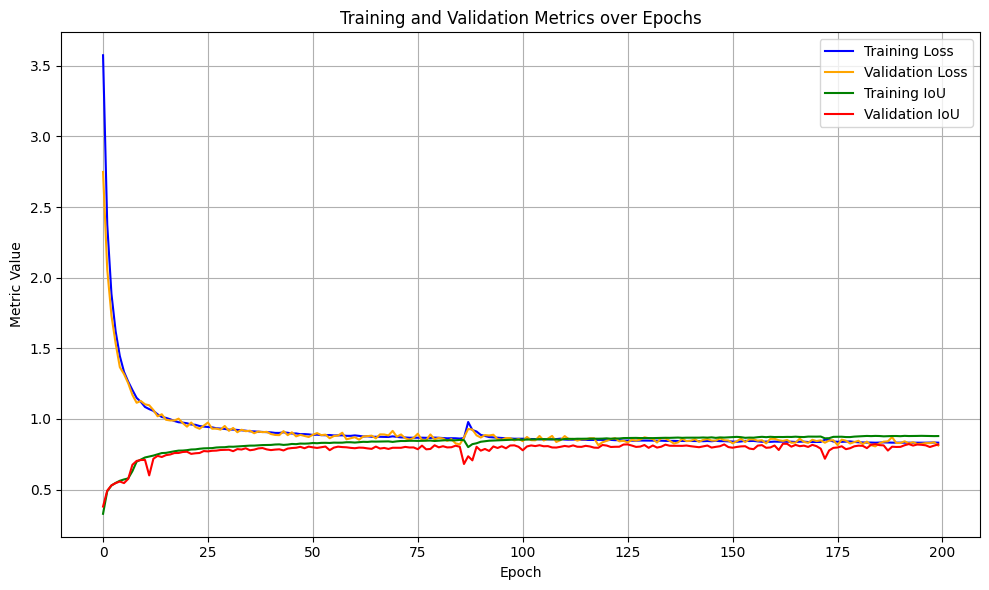

In [25]:
# Step 17: Visualize Training and Validation Metrics
plt.figure(figsize=(10, 6))

# Plotting Training Loss
plt.plot(train_loss_hist, label='Training Loss', color='blue')

# Plotting Validation Loss
plt.plot(val_loss_hist, label='Validation Loss', color='orange')

plt.plot(train_iou_hist, label='Training IoU', color='green')

# Plotting Validation IoU
plt.plot(val_iou_hist, label='Validation IoU', color='red')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training and Validation Metrics over Epochs')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [26]:
# Step 18: Save Model Weights
torch.save(model.cpu().state_dict(), model_path)

In [27]:
color_encoding = [
                ('a', (0, 0, 0)),    # Black
                ('b', (255, 0, 0)),  # Red
                ('c', (0, 255, 0)),  # Green
                ('d', (0, 0, 255)),  # Blue
                ('e', (255, 255, 0)),  # Yellow
                ('f', (0, 255, 255))   # Cyan
]

num_classes=7

def label_for_cross_entropy(label):
    """
        Convert label image to matrix classes for apply cross entropy loss.
        Return semantic index, label in enumemap of H x W x class
    """
    semantic_map = np.zeros(label.shape[:-1])
    # Fill all value with class 13 - default for all pixels
    semantic_map.fill(num_classes - 1)
    # Fill the pixel with correct class

    for class_index, color_info in enumerate(color_encoding):
        color = color_info[1]
        equality = np.equal(label, color)
        class_map = np.all(equality, axis=-1)
        semantic_map[class_map] = class_index
    return semantic_map

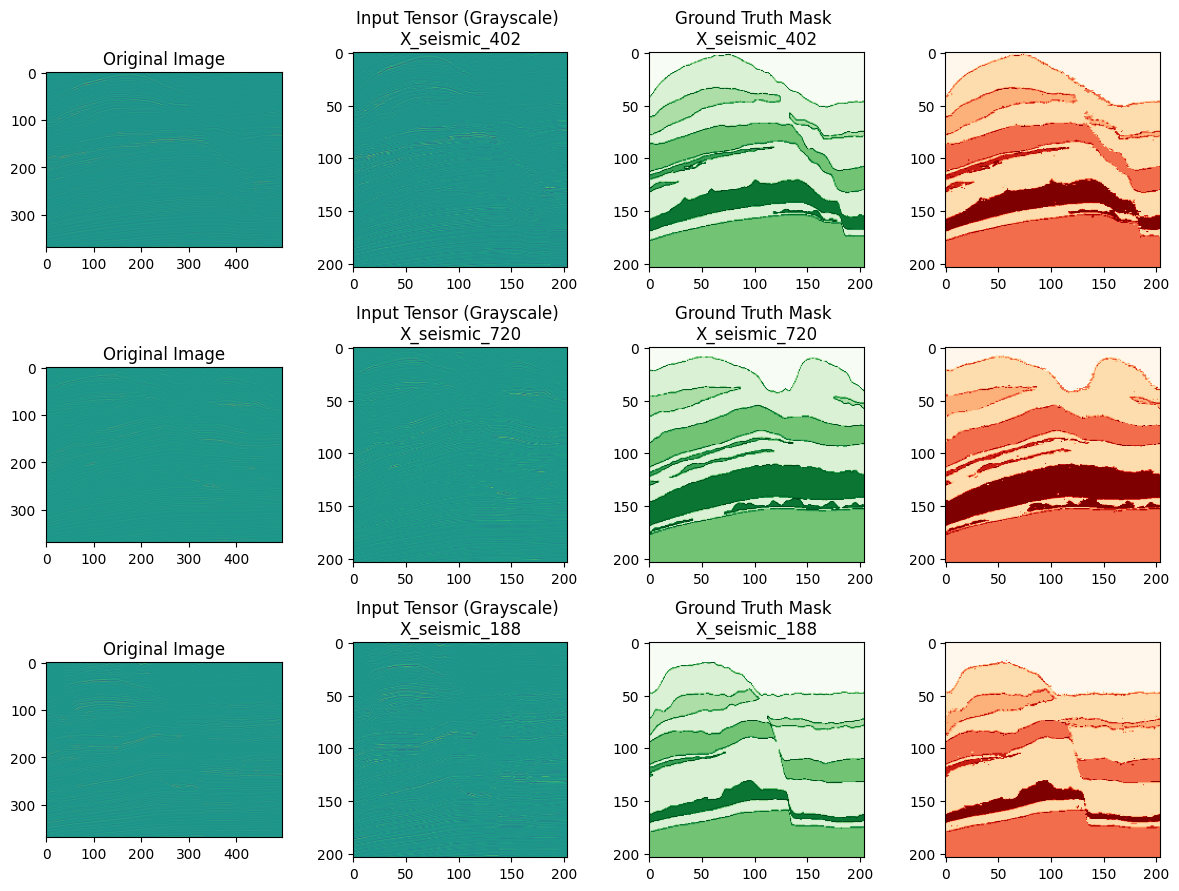

In [30]:
# Step 20: Evaluate Model on Sample Images
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Define the sample image names
names = ['X_seismic_402', 'X_seismic_720', 'X_seismic_188']
names2 = ['X_mask_402', 'X_mask_720', 'X_mask_188']

val_image_path = '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic'
val_mask_path = '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask'

# Load the sample images and masks
images = [Image.open(os.path.join(val_image_path, name+'.png')) for name in names]
images = [i.convert('RGB') for i in images]

masks = [Image.open(os.path.join(val_mask_path, name+'.png')) for name in names2]
masks = [i.convert('RGB') for i in masks]
masks = [np.array(i) for i in masks]
masks = [label_for_cross_entropy(i) for i in masks]
masks = [Image.fromarray(i) for i in masks]

# Apply transformations to convert images to tensors
transforms = T.Compose([T.ToTensor(), T.Resize((204, 204))])
x = torch.stack([transforms(image) for image in images])
y = torch.stack([transforms(mask) for mask in masks])

# Generate predictions using the model
# Assuming 'x' is your input tensor
x = x.to(device)  # Move input tensor to the same device as the model

# Generate predictions using the model
outputs, _, _ = model(x)
outputs =  outputs.squeeze()

output_temps = outputs 
outputs = np.array(outputs.detach().cpu())

# val_label = val_label.squeeze()
# val_label = np.array(val_label)

# Visualize the sample images, ground truth masks, and model predictions
fig = plt.figure(figsize=(12, 9))
for i in range(len(names)):
    # Plot original image
    ax = fig.add_subplot(3, 4, i*4+1)
    plt.imshow(images[i])
    ax.set_title("Original Image")

    # Plot input tensor
    ax = fig.add_subplot(3, 4, i*4+2)
    # Assuming x is your tensor on a CUDA device (GPU)
    # Move tensor x to CPU and then convert it to a NumPy array
    x_numpy = x[i].squeeze().cpu().numpy()
    
    x_numpy = np.transpose(x_numpy, (1, 2, 0))
    
    ax.imshow(x_numpy.squeeze(), cmap="Greys")
    ax.set_title(f'Input Tensor (Grayscale) \n{names[i]}')

    # Plot ground truth mask
    ax = fig.add_subplot(3, 4, i*4+3)
    ax.imshow(y[i].squeeze(), cmap="Greens")
    ax.set_title(f'Ground Truth Mask \n{names[i]}')
    
    # Plot model prediction
    ax = fig.add_subplot(3, 4, i*4+4)
    # Move tensor from GPU to CPU and then convert it to a NumPy array
    output = outputs[i].squeeze()
    
    # Convert NumPy array to PyTorch tensor
    output_tensor = torch.from_numpy(output)
    
    class_labels = torch.argmax(output_tensor, dim=0)
    class_labels_np = class_labels.cpu().numpy().astype(np.uint8)
    
    ax.imshow(class_labels_np, cmap="OrRd")
#     ax.set_title("Model Prediction\nmIoU: " + str(round(df_sorted[df_sorted['name'] == names[i]]['IoU'].values[0], 3)))

plt.tight_layout()
plt.show()